### Descriptive statistics for human response times and uncertainty measures.

In this notebook we perform the statistical analysis on the Levels dataset.

In [ ]:
## Data imports
import pickle
import re
import os
import json
import scipy
import random
from scipy.stats import t, ttest_rel

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from typing import Dict, List, Tuple, Union
from collections import defaultdict, Counter

### Utility functions for loading and processing human similarity judgment data

In [ ]:
## Load and process the human response data
def load_response_data(path_to_responses: str) -> List[Dict[str, Union[float, int, str]]]:
    """Load human odd-one-out responses from disk."""
    trials = []
    for file in os.scandir(path_to_results):
        if file.name.endswith(".json"):
            with open(file, "r") as f:
                for line in f:
                    trials.append(json.loads(line))
    return trials


def image_name_to_idx_mapping(image_root: str) -> Dict[str, int]:
    """Create a mapping from WordNet IDs to indices."""
    images = list(filter(lambda x: x.endswith(".JPEG"), os.listdir(image_root)))
    name2idx = {name: idx for idx, name in enumerate(sorted(images))}
    return name2idx


def filter_variables(
    trials: List[Dict[str, Union[float, int, str]]]
) -> Dict[str, List[Dict[str, Union[float, str]]]]:
    """Filter variables that are crucial for further analyses."""
    excluded_trials = 0
    excluded_participants = []
    participants = defaultdict(list)
    for trial in trials:
        if trial["subject_id"] != None and "selected_image" in trial:
            sbj_id = trial["subject_id"].split("_")[-1]
            sbj_id = int(sbj_id)
            if sbj_id in EXCLUDE:
                excluded_participants.append(sbj_id)
                excluded_trials += 1
                continue
            selected_image = trial["selected_image"]
            if isinstance(selected_image, str):
                if selected_image != "No image selected":
                    filtered_trial = {}
                    for var in variables:
                        if re.search(r"image", var):
                            val = trial[var].split("/")[-1]
                        else:
                            val = trial[var]
                        filtered_trial[var] = val
                    participants[trial["subject_id"]].append(filtered_trial)
    excluded_participants = set(excluded_participants)
    print(f"\nExcluded {excluded_trials} trials from data.\n")
    print(f"\nExcluded participants: {excluded_participants} from data.\n")
    return participants


def get_wn_ids(
    trial: Dict[str, Union[float, str]]) -> List[str]:
    """Extract WordNet IDs from images used in an experimental trial."""
    wn_ids = []
    for k, v in trial.items():
        if k.startswith("image"):
            wn_id = v.split("_")[0]
            wn_ids.append(wn_id)
    assert len(wn_ids) == 3
    return wn_ids


def get_triplet_type(
    trial_types: Dict[int, str], wn_ids: List[str]) -> str:
    """Retrieve triplet type from WordNet IDs."""
    unique_wn_ids = set(wn_ids)
    triplet_type = trial_types[len(unique_wn_ids)]
    return triplet_type


def process_participant_data(
    participants: Dict[str, List[Dict[str, Union[float, str]]]],
) -> Dict[str, List[Dict[str, Union[float, str]]]]:
    """Add the correct triplet types to each experimental trial."""
    trial_types = {1: "within_class", 2: "class_border", 3: "between_class"}
    participants_processed = {}
    for participant, trials in participants.items():
        participant_trials = []
        for trial in trials:
            wn_ids = get_wn_ids(trial)
            triplet_type = get_triplet_type(trial_types, wn_ids)
            exp_trial_type = trial["exp_trial_type"]
            if exp_trial_type == "catch_trial":
                assert triplet_type == "class_border"
                continue
            # add the triplet type to trial
            trial.update({"triplet_type": triplet_type})
            participant_trials.append(trial)
        participants_processed[participant] = participant_trials
    return participants_processed


def get_image_triplet(
    trial: Dict[str, Union[float, str]],
) -> Tuple[str]:
    triplet = sorted([v for k, v in trial.items() if k.startswith("image")])
    triplet = tuple([img_name.split("/")[-1].split(".")[0] for img_name in triplet])
    return triplet


def count_triplets(
    participants_processed: Dict[str, List[Dict[str, Union[float, str]]]],
) -> Dict[Tuple[str], int]:
    """Count the number of responses for each triplet in the data."""
    triplet_counts = defaultdict(int)
    for trials in participants_processed.values():
        for trial in trials:
            # filter experimental trials
            if trial["exp_trial_type"] == "exp_trial":
                triplet = get_image_triplet(trial)
                triplet_counts[triplet] += 1
    return triplet_counts
    

def filter_triplets(
    triplet_counts:  Dict[Tuple[str], int],
    max_count: int = 5,
    min_count: int = 4,
) -> List[Tuple[str]]:
    """Filter all triplets in the data for which there exist too many or too few responses."""
    triplets_to_discard, _ = zip(*list(filter(lambda kv: kv[1] > max_count or kv[1] < min_count, triplet_counts.items())))
    return list(triplets_to_discard)


def prune_processed_data(
    participants_processed: Dict[str, List[Dict[str, Union[float, str]]]],
) -> Dict[str, List[Dict[str, Union[float, str]]]]:
    """Discard triplets for which there exist too many or too few responses."""
    triplet_counts = count_triplets(participants_processed)
    triplets_to_discard = filter_triplets(triplet_counts)
    print(f"\nTotal number of (experimental) triplets in the data: {len(triplet_counts)}")
    print(f"Number of (experimental) triplets that we want to discard: {len(triplets_to_discard)}\n")
    pruned_participant_data = {}
    for participant, trials in participants_processed.items():
        filtered_trials = []
        for trial in trials:
            # Filter experimental trials
            if trial["exp_trial_type"] == "exp_trial":
                triplet = get_image_triplet(trial)
                if not triplet in triplets_to_discard:
                    filtered_trials.append(trial)
        pruned_participant_data[participant] = filtered_trials
    return pruned_participant_data


def partition_into_triplet_types(
    participants: Dict[str, List[Dict[str, Union[float, str]]]],
) -> Dict[str, List[Dict[str, Union[float, str]]]]:
    """Partition the human response data into the different triplet types."""
    triplet_types = defaultdict(lambda: defaultdict(list))
    for participant, trials in participants.items():
        for trial in trials:
            if trial["exp_trial_type"] == "exp_trial":
                triplet = sorted([v for k, v in trial.items() if k.startswith("image")])
                triplet_type = trial["triplet_type"]
                selected_image = trial["selected_image"]
                choice = triplet.index(selected_image)
                response = {"choice": choice, "rt": np.log(trial["rt"] / 1000.) }
                triplet_types[triplet_type][tuple(triplet)].append(response)
    return triplet_types

def sample_responses(
    responses: List[Dict[str, Union[int, float]]],
    max_num_responses: int = 5,
) -> List[Dict[str, Union[float, str]]]:
    """From all responses for a triplet, randomly sample a subset of <max_num_responses>."""
    rnd_subset = np.random.choice(np.arange(len(responses)), size=max_num_responses, replace=False)
    sampled_responses = [response for i, response in enumerate(responses) if i in rnd_subset]
    return sampled_responses


def unzip_responses(
    responses: List[Dict[str, Union[int, float]]],
) -> Tuple[List[str], List[float]]:
    """Partition the responses into odd-one-out choices and response times."""
    return zip(*[response.values() for response in responses])


def get_rts_per_triplet_type(
    triplet_types: Dict[str, List[Dict[str, Union[float, str]]]],
) -> Dict[str, List[float]]:
    """For each triplet type, get the RTs of every triplet and participant (not just the averaged ones)."""
    rts_per_triplet_type = defaultdict(list)
    for triplet_type, triplets in triplet_types.items():
        for triplet, responses in triplets.items():
            _, rts = unzip_responses(responses)
            rts_per_triplet_type[triplet_type].extend(rts)
    return rts_per_triplet_type


def entropy(p: np.ndarray) -> float:
    """Compute the Shannon entropy of a discrete probability distribution."""
    return -np.sum(np.where(p == 0., 0., p*np.log(p)))


def filter_responses(
    triplet_types: Dict[str, Dict[Tuple[str], List[Dict[str, Union[int, float]]]]], 
    k: int = 3,
    min_num_responses: int = 4,
    max_num_responses: int = 5,
) -> Dict[str, Dict[Tuple[str], List[Dict[str, Union[int, float]]]]]:
    """For each type of triplets, filter the triplet odd-one-out responses."""
    filtered_responses = defaultdict(dict)
    for triplet_type, triplets in triplet_types.items():
        for triplet, responses in triplets.items():
            num_responses = len(responses)            
            if num_responses < min_num_responses:
                continue
            elif num_responses > max_num_responses:
                responses = sample_responses(responses=responses, max_num_responses=max_num_responses)
            filtered_responses[triplet_type][triplet] = responses
    return filtered_responses


def get_response_counts(choices: List[int]):
    """Count the triplet odd-one-out responses for a unique triplet."""
    response_counts = Counter(choices)
    sorted_counts = sorted(response_counts.items(), key=lambda kv:kv[1], reverse=True)
    return sorted_counts


def get_majority_vote(choices: List[int]) -> Union[int, Tuple[int]]:
    """Get the population's majority response."""
    response_counts = get_response_counts(choices)
    majority_response = response_counts[0]
    second_response = response_counts[1]
    if majority_response[1] > second_response[1]:
        majority_vote = majority_response[0]
    else:
        majority_vote = (majority_response[0], second_response[0])
    return majority_vote


def compute_response_distribution(
    response_counts: Dict[int, int],
    num_responses: int,
    k: int = 3,
) -> np.ndarray:
    """For a set of triplet odd-one-out responses, compute its response distribution."""
    response_distribution = np.zeros(k, dtype=np.float64)
    for response, counts in response_counts:
        response_distribution[response] = counts
    response_distribution /= num_responses
    return response_distribution


def aggregate_responses(
    filtered_responses: Dict[str, List[Dict[str, Union[float, str]]]], 
    k: int = 3,
    min_num_responses: int = 4,
    max_num_responses: int = 5,
) -> Dict[str, Dict[Tuple[str], Dict[str, Union[float, int, np.ndarray]]]]:
    """Aggregate the triplet odd-one-out responses across participants."""
    majority_votes = defaultdict(dict)
    for triplet_type, triplets in filtered_responses.items():
        for triplet, responses in triplets.items():
            choices, rts = unzip_responses(responses)
            
            # NOTE: the line below is necessary because we calculate the human noise ceiling using a LOO method
            choices = np.random.choice(choices, size=min_num_responses, replace=False).tolist()
            
            if len(set(choices)) == 1:
                majority_vote = choices.pop()
                response_distribution = np.zeros(k, dtype=np.float64)
                response_distribution[majority_vote] += 1.
            else:
                num_responses = len(choices)
                majority_vote = get_majority_vote(choices)
                response_counts = get_response_counts(choices)
                response_distribution = compute_response_distribution(
                    response_counts=response_counts, num_responses=num_responses, k=k)
            
            avg_rt = np.mean(rts)
            aggregated_response = {
                "majority_response": majority_vote,
                "uncertainty": response_distribution,
                "avg_rt": avg_rt,
                "entropy": entropy(response_distribution),
            }
            majority_votes[triplet_type][triplet] = aggregated_response
    
    return majority_votes


def get_uncertainty_measures(
    majority_votes: Dict[str, Dict[Tuple[int], Dict[str, Union[float, int, np.ndarray]]]]
) -> Dict[str, Dict[str, List[float]]]:
    """For each triplet in the data, get human uncertainty measures (RTs and entropies)."""
    noise_ceilings = dict()
    uncerainty_measures = defaultdict(lambda: defaultdict(list))
    overall_uncertainties = []
    for triplet_type, triplets in majority_votes.items():
        uncertainties = np.zeros((len(triplets), 3), dtype=np.float64)
        for i, (triplet, avg_response) in enumerate(triplets.items()):
            uncertainty = avg_response["entropy"]
            avg_rt = avg_response["avg_rt"]
            uncerainty_measures["entropies"][triplet_type].append(uncertainty)
            uncerainty_measures["avg_rts"][triplet_type].append(avg_rt)
            uncertainties[i] += avg_response["uncertainty"]
        noise_ceiling = np.max(uncertainties, axis=-1).mean()
        noise_ceilings[triplet_type] = noise_ceiling
        overall_uncertainties.extend(uncertainties.tolist())
    overall_uncertainties = np.asarray(overall_uncertainties)
    overall_noise_ceiling = np.max(overall_uncertainties, axis=-1).mean()
    print(f"\nNoise ceiling across all triplets: {overall_noise_ceiling:.4f}\n")
    return uncerainty_measures, noise_ceilings
    

def convert_names_to_indices(
    majority_votes: Dict[str, Dict[Tuple[str], Dict[str, Union[float, int, np.ndarray]]]],
    name2idx: Dict[str, int],
) -> Dict[str, Dict[Tuple[int], Dict[str, Union[float, int, np.ndarray]]]]:
    """Conver the WordNet IDs to indices. Important for analyzing the models."""
    majority_votes_indices = defaultdict(dict)
    for triplet_type, triplets in majority_votes.items():
        for triplet, response in triplets.items():
            triplet_indices = tuple(name2idx[n] for n in triplet)
            majority_votes_indices[triplet_type][triplet_indices] = response
    return majority_votes_indices


def get_ooo_choices(
    majority_votes_indices: Dict[str, Dict[Tuple[str], Dict[str, Union[float, int, np.ndarray]]]]
) -> Dict[str, List[List[int]]]:
    """Sort the triplets according to the majority response. Last index is OOO."""
    mask = -99
    triplet_choices = defaultdict(list)
    for triplet_type, triplets in majority_votes_indices.items():
        for triplet, responses in triplets.items():
            triplet = list(triplet)
            choice_idx = responses["majority_response"]
            if isinstance(choice_idx, tuple):
                for idx in choice_idx:
                    choice = triplet.pop(idx)
                    triplet.append(choice)
                triplet.append(mask)
            else:
                choice = triplet.pop(choice_idx)
                triplet.append(choice)
            triplet_choices[triplet_type].append(triplet)
    return triplet_choices

In [5]:
def get_triplet_certainty(choices: List[int]) -> float:
    """For a unique triplet, compute the population's certainty (agreement level) using a LOO method."""
    matches = 0
    num_choices = len(choices)
    for i in range(num_choices):
        sample = [c for j, c in enumerate(choices) if j != i]
        loo_choice = choices[i]
        
        if len(set(sample)) == 1:
            majority_vote = sample.pop()
        else:
            majority_vote = get_majority_vote(choices=sample)
        
        if isinstance(majority_vote, tuple):
            if loo_choice in majority_vote:
                matches += .5
        else:
            if loo_choice == majority_vote:
                matches += 1
                
    triplet_certainty = matches / num_choices
    return triplet_certainty


def compute_human_noise_ceilings(
    filtered_responses: Dict[str, Dict[Tuple[str], List[Dict[str, Union[int, float]]]]],
) -> Dict[str, float]:
    """Compute the human noise ceiling level using a Leave-One-Out (LOO) method for every unique triplet."""
    noise_ceilings = {}
    overall_certainties = []
    for triplet_type, triplets in filtered_responses.items():
        triplet_certainties = []
        for triplet, responses in triplets.items():
            choices, _ = unzip_responses(responses)
            unique_choices = set(choices)
            
            if len(unique_choices) == 1:
                triplet_certainty = 1.
            else:
                triplet_certainty = get_triplet_certainty(choices)

            triplet_certainties.append(triplet_certainty)
            overall_certainties.append(triplet_certainty)

        noise_ceiling = np.mean(triplet_certainties)
        noise_ceilings[triplet_type] = noise_ceiling

    overall_noise_ceiling = np.mean(overall_certainties)
    print(f"\nNoise ceiling across all triplets: {overall_noise_ceiling:.4f}\n")
    return noise_ceilings

In [6]:
# directories
triplet_root = "../human_eval/data/evaluation/triplets/"
image_root = "/Users/born/Documents/GitHub_Projects/HumanEval/client/public/stimuli/imagenet2012_human_eval_v2.1_images/train"
path_to_results = "/Users/born/Downloads/nonidentifiable_results_exp_final_exc_perf_outliers"

In [7]:
# fix the random seed for reproducibility of results (always re-run from this cell)
rnd_seed = 42
random.seed(rnd_seed)
np.random.seed(rnd_seed)

In [8]:
# variables that we want to keep for further analyses
variables = ["rt", "image1Path", "image2Path", "image3Path", "selected_image", "exp_trial_type"]
# participants we want to exclude from any analyses
EXCLUDE = [] # sorted([133, 306, 275, 317, 34])

In [9]:
# load human response data and process it
trials = load_response_data(path_to_results)
participants = filter_variables(trials)
participants_processed = process_participant_data(participants)
name2idx = image_name_to_idx_mapping(image_root)


Excluded 0 trials from data.


Excluded participants: set() from data.



In [10]:
triplet_responses = partition_into_triplet_types(participants_processed)
filtered_responses = filter_responses(triplet_responses)

In [11]:
# Print the number of trials for each triplet type
for triplet_type, triplets in triplet_responses.items():
    trial_count = sum(len(trials) for trials in triplets.values())
    print(f"Triplet Type: {triplet_type}, Number of Trials: {trial_count}")


Triplet Type: between_class, Number of Trials: 61727
Triplet Type: within_class, Number of Trials: 62549
Triplet Type: class_border, Number of Trials: 30826


In [12]:
# get the reaction times for every triplet and participant in the data (not just averaged ones)
rts_per_triplet_type = get_rts_per_triplet_type(filtered_responses)

In [13]:
# aggregate triplet responses and convert names to indices
majority_votes = aggregate_responses(filtered_responses)
majority_votes_indices  = convert_names_to_indices(majority_votes, name2idx)

/var/folders/y6/s5d79fxx4vn9jfrsc8vq3ns5rv4nmx/T/ipykernel_73923/496682905.py:194: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.where(p == 0., 0., p*np.log(p)))
/var/folders/y6/s5d79fxx4vn9jfrsc8vq3ns5rv4nmx/T/ipykernel_73923/496682905.py:194: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(np.where(p == 0., 0., p*np.log(p)))


In [14]:
loo_noise_ceilings = compute_human_noise_ceilings(filtered_responses)
ooo_choices = get_ooo_choices(majority_votes_indices)
uncertainty_measures, vanilla_noise_ceilings = get_uncertainty_measures(majority_votes_indices)


Noise ceiling across all triplets: 0.6896


Noise ceiling across all triplets: 0.7893



In [15]:
def plot_uncertainties(
    uncertainty_measures: Dict[str, Dict[str, List[float]]],
    path_to_figures: str,
) -> None:
    """Plot the distribution of entropies for each triplet type as a histogramm + KDE."""
    entropies = uncertainty_measures["entropies"]
    fig, axes = plt.subplots(1, len(entropies), figsize=(14, 4), dpi=200)
    for i, ax in enumerate(axes):
        sns.histplot(
            x=entropies[TRIPLET_TYPES[i]],
            bins=10, # we could change the number of bins but I think 10 is reasonable for an upper-bound of log(3)
            kde=True,
            ax=ax,
            stat="probability", # can be changed to 'counts' or 'density'
            alpha=0.5,
            color=COLORS[i],
        )
        ax.set_xlabel("Uncertainty", fontsize=13)
        if i == 0:
            ax.set_ylabel("Probability", labelpad=15, fontsize=13)
        else:
            ax.set_ylabel("")
        ax.set_title(NAME_MAPPING[TRIPLET_TYPES[i]], fontsize=14)
    fig.tight_layout()
    plt.savefig(os.path.join(path_to_figures, "human_uncertainties.pdf"), bbox_inches="tight")
    plt.show()
    

def plot_rts_vs_entropies(
    uncertainty_measures: Dict[str, Dict[str, List[float]]],
    path_to_figures: str,
) -> None:
    """Plot the (average) RTs in log-space against uncertainties over the triplets."""
    reaction_times = uncertainty_measures["avg_rts"]
    entropies = uncertainty_measures["entropies"]
    fig, axes = plt.subplots(1, len(TRIPLET_TYPES), figsize=(14, 4), dpi=200)
    for i, ax in enumerate(axes):
        x = reaction_times[TRIPLET_TYPES[i]]
        y = entropies[TRIPLET_TYPES[i]]
        # compute Pearson correlation coefficient between RTs and entropies
        # pearson_corr = scipy.stats.pearsonr(x, y)[0]
        spearman_rank = scipy.stats.spearmanr(x, y)[0]
        sns.regplot(
            x=x,
            y=y,
            color=COLORS[i], 
            x_ci="sd", # can be changed to 'ci' (95% Confidence Interval)
            scatter_kws={
                "alpha": 0.5,
                "color": COLORS[i],
            },
            line_kws={"color": "dimgrey"},
            ax=ax,
        )
        # response times are computed in log-space
        ax.set_xlabel("Response Time (log-space)", fontsize=15, labelpad=10)
        if i == 0:
            ax.set_ylabel("Uncertainty", labelpad=10, fontsize=16)
        ax.annotate(r"$\rho=$"+f"{spearman_rank:.3f}", xy=(np.max(x)-0.5, np.min(y)+.1), fontsize=14)
        ax.set_title(NAME_MAPPING[TRIPLET_TYPES[i]], fontsize=15)
    fig.tight_layout()
    plt.savefig(os.path.join(path_to_figures, "rts_vs_entropies.pdf"), bbox_inches="tight")
    plt.show()

In [24]:
def plot_rts_vs_entropies(
    uncertainty_measures: Dict[str, Dict[str, List[float]]],
    path_to_figures: str,
) -> None:
    """Plot the (average) RTs in log-space against uncertainties over the triplets."""
    reaction_times = uncertainty_measures["avg_rts"]
    entropies = uncertainty_measures["entropies"]
    fig, axes = plt.subplots(1, len(TRIPLET_TYPES), figsize=(18, 5), dpi=200)
    for i, ax in enumerate(axes):
        x = reaction_times[TRIPLET_TYPES[i]]
        y = entropies[TRIPLET_TYPES[i]]
        # compute Pearson correlation coefficient between RTs and entropies
        spearman_rank = scipy.stats.spearmanr(x, y)[0]
        sns.regplot(
            x=x,
            y=y,
            color=COLORS[i], 
            x_ci="sd", # can be changed to 'ci' (95% Confidence Interval)
            scatter_kws={
                "alpha": 0.5,
                "color": COLORS[i],
            },
            line_kws={"color": "dimgrey"},
            ax=ax,
        )
        # response times are computed in log-space
        ax.set_xlabel("Response Time (log-space)", fontsize=22, labelpad=10)
        if i == 0:
            ax.set_ylabel("Uncertainty", labelpad=10, fontsize=22)
        ax.annotate(r"$\rho=$"+f"{spearman_rank:.3f}", xy=(np.max(x)-0.5, np.min(y)+.1), fontsize=14)
        
        
        # Set x and y axis limits
        ax.set_xlim(0.0, 2.3)
        ax.set_ylim(-0.2, 1.2)

        # Increase tick label size
        ax.tick_params(axis='both', which='major', labelsize=12)
        
    fig.tight_layout()
    plt.savefig(os.path.join(path_to_figures, "rts_vs_entropies2.pdf"), bbox_inches="tight")
    plt.show()

In [18]:
import os

# Get the current working directory (relative to where you launched the script)
current_dir = os.getcwd()

# Now make a "figures" subfolder inside it
path_to_figures = os.path.join(current_dir, "figures")

# Now create it if it doesn't exist
os.makedirs(path_to_figures, exist_ok=True)


In [17]:
# global variables for visualizing the data
NAME_MAPPING = {
    "class_border": "Class-boundary",
    "between_class": "Coarse-grained semantic", 
    "within_class": "Fine-grained semantic",
}
# COLORS = [
#    "darkorange",
#    "purple",
#    "cornflowerblue",
# ]
COLORS = [
    "#86be91",
    "#1d6c8a",
    "#841e5a",
]
TRIPLET_TYPES = list(triplet_responses.keys())

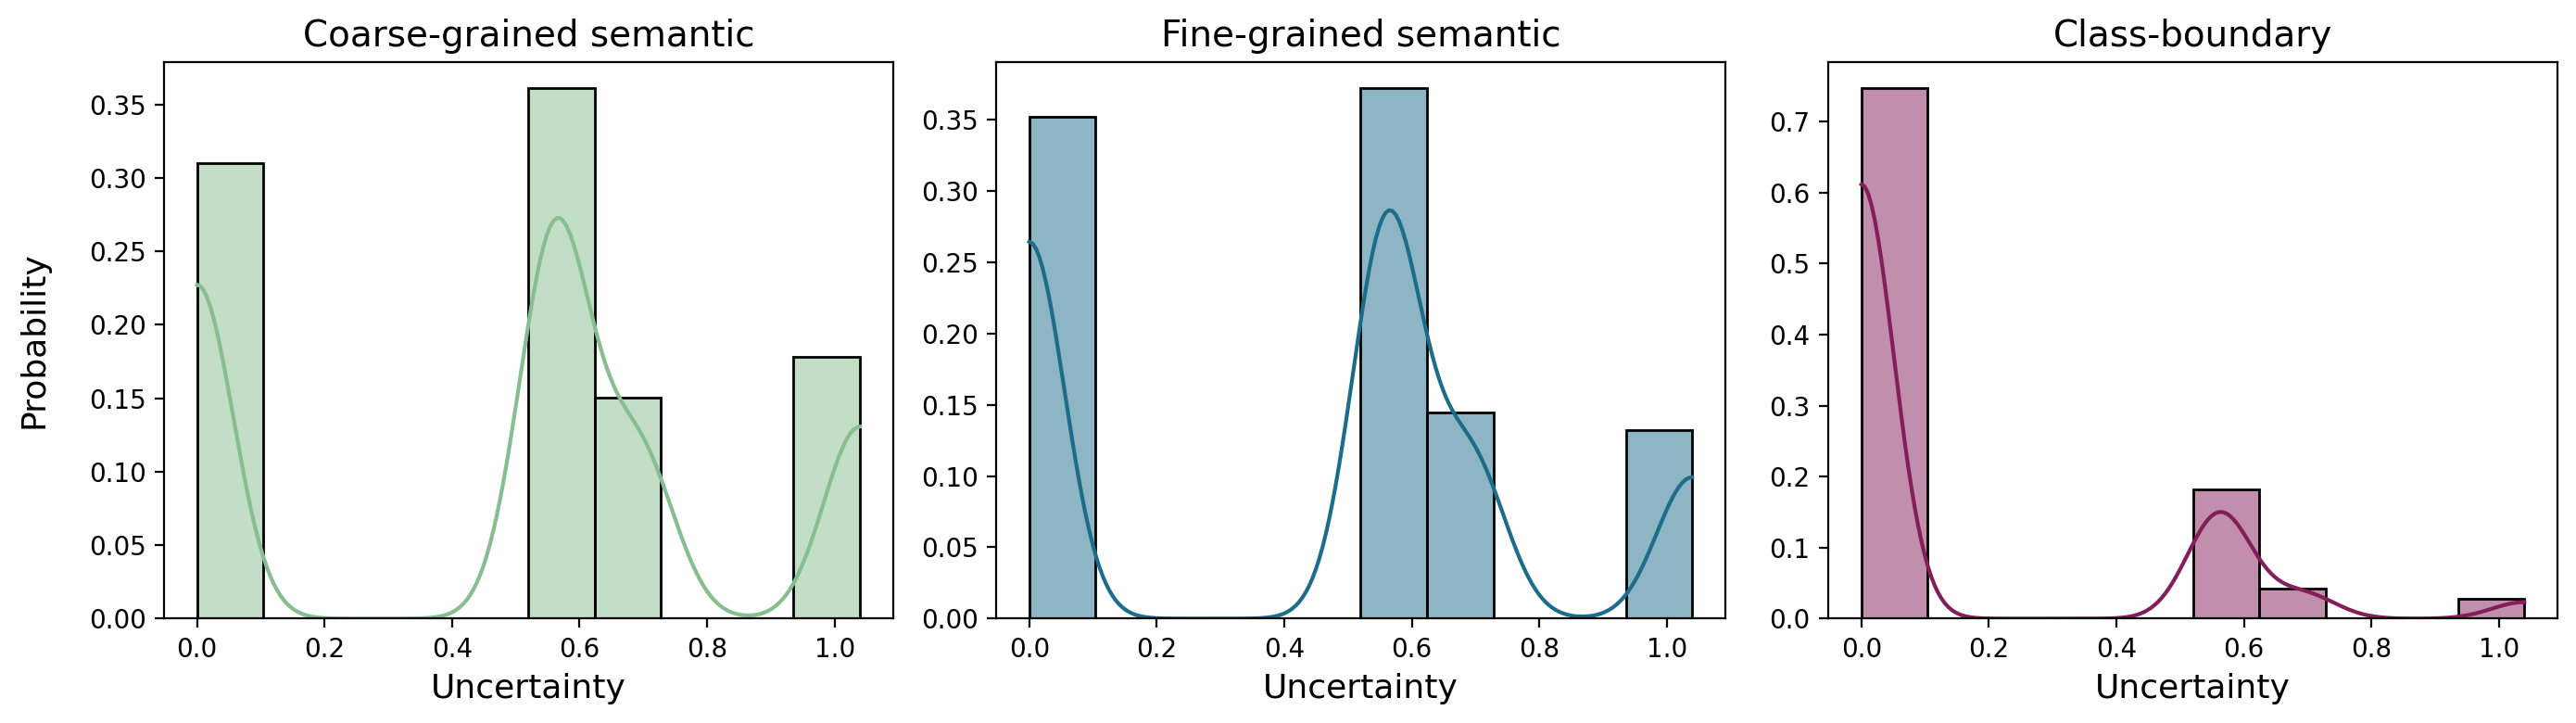

In [19]:
# plot distribution of entropies for each triplet type
plot_uncertainties(uncertainty_measures, path_to_figures)

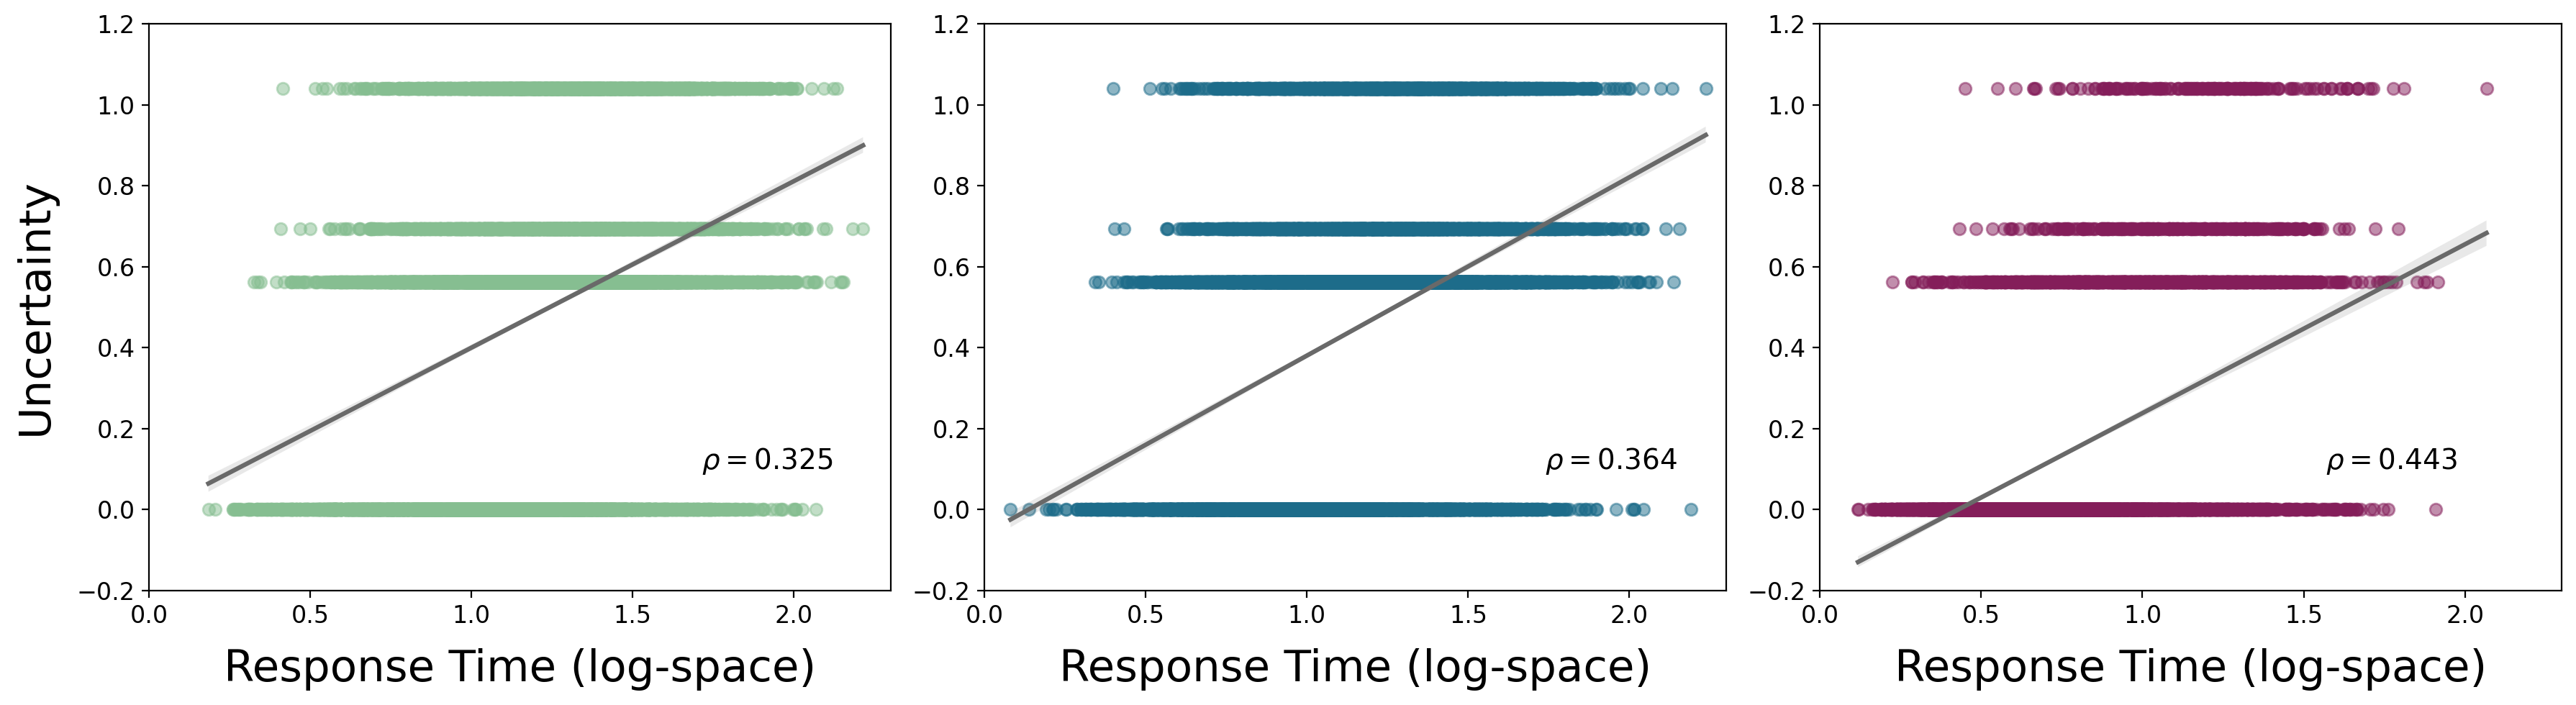

In [25]:
# plot the average RTs in log-space against uncertainties / entropies for each triplet type
plot_rts_vs_entropies(uncertainty_measures, path_to_figures)

In [21]:
# Assuming you have these dictionaries
reaction_times = uncertainty_measures["avg_rts"]
entropies = uncertainty_measures["entropies"]

# Dictionary to store Spearman correlation results
spearman_results = {}

for triplet_type in TRIPLET_TYPES:
    x = reaction_times[triplet_type]
    y = entropies[triplet_type]
    
    # Compute Spearman correlation coefficient and p-value
    spearman_corr, spearman_p_value = scipy.stats.spearmanr(x, y)
    
    # Store the results
    spearman_results[triplet_type] = {
        "correlation": spearman_corr,
        "p_value": spearman_p_value
    }

# Print Spearman correlation results
for triplet_type, stats in spearman_results.items():
    print(f"{triplet_type}: Spearman correlation = {stats['correlation']:.3f}, p-value = {stats['p_value']:.3e}")


between_class: Spearman correlation = 0.325, p-value = 4.660e-289
within_class: Spearman correlation = 0.364, p-value = 0.000e+00
class_border: Spearman correlation = 0.443, p-value = 2.477e-282


In [22]:
# you need this code to convert the dictionaries into a Pandas DataFrame

num_total_responses = sum([len(triplets) for triplets in majority_votes_indices.values()])
df = pd.DataFrame(index=range(num_total_responses), columns=["triplet_type", "reaction_time", "uncertainty"])
i = 0
for triplet_type, triplets in majority_votes_indices.items():
    for triplet, responses in triplets.items():
        df.loc[i, "triplet_type"] = NAME_MAPPING[triplet_type]
        df.loc[i, "reaction_time"] = responses["avg_rt"]
        df.loc[i, "uncertainty"] = abs(responses["entropy"])
        i += 1

df = df.astype({'triplet_type': str, 'reaction_time': float, "uncertainty": float})

/var/folders/y6/s5d79fxx4vn9jfrsc8vq3ns5rv4nmx/T/ipykernel_73923/3446539563.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(x="triplet_type", y="reaction_time", data=df, hue="triplet_type", dodge=False,
/var/folders/y6/s5d79fxx4vn9jfrsc8vq3ns5rv4nmx/T/ipykernel_73923/3446539563.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklables, fontsize=16)
/var/folders/y6/s5d79fxx4vn9jfrsc8vq3ns5rv4nmx/T/ipykernel_73923/3446539563.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklables, fontsize=16)


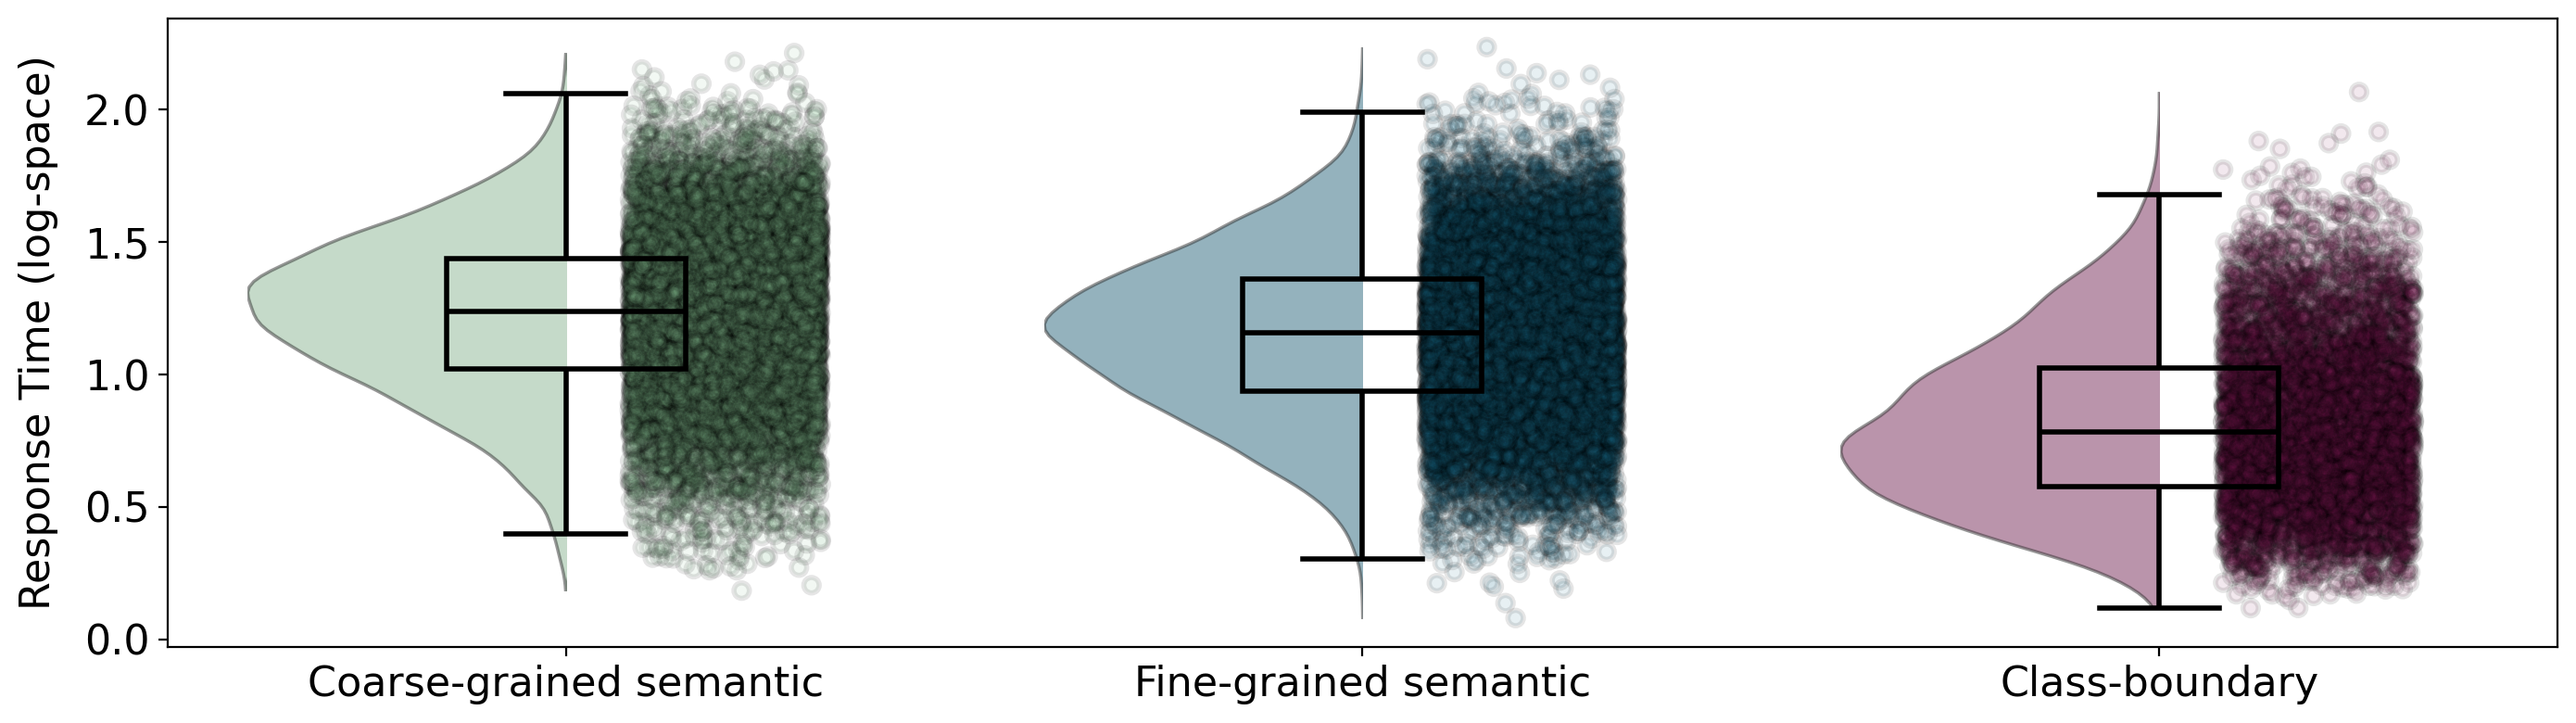

In [23]:
# Color settings
colors = {
    "Coarse-grained semantic":  "#86be91",
    "Fine-grained semantic":  "#1d6c8a",
    "Class-boundary": "#841e5a",
}
fig, ax = plt.subplots(1, 1, figsize=(14, 4), dpi=200)
# Create half-violin plots
ax = sns.violinplot(x="triplet_type", y="reaction_time", data=df, hue="triplet_type", dodge=False,
                    palette=colors,
                    scale="width", inner=None, cut=0,alpha=0.5)

for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))

# Add boxplot for median and quartiles
sns.boxplot(x="triplet_type", y="reaction_time", data=df, saturation=1, showfliers=False, color = 'black',
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none', 'linewidth': 2}, linewidth=2, ax=ax)  # Increased linewidth

# Additional stripplot with adjusted positioning and transparency
sns.stripplot(x="triplet_type", y="reaction_time", data=df, hue="triplet_type", palette=colors, dodge=False, ax=ax, jitter=0.12, alpha=0.1, zorder=2,
              marker='o', edgecolor='black', linewidth=2, size=6)  # Added edgecolor and linewidth for a 3D effect
for dots in ax.collections[-3:]:  # Only adjust the new dots
    dots.set_offsets(dots.get_offsets() + np.array([0.2, 0]))  # Move to the left


# Set limits and remove legend
xlim = ax.get_xlim()
ylim = ax.get_ylim()
yticklables = ax.get_yticklabels()
xticklables = ax.get_xticklabels()
ax.set_xticklabels(xticklables, fontsize=16)
ax.set_yticklabels(yticklables, fontsize=16)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("")
ax.set_ylabel("Response Time (log-space)", fontsize=16, labelpad=10)
fig.tight_layout()
if ax.legend_:
    ax.legend_.remove()
plt.savefig(os.path.join(path_to_figures, "rt_distributions.png"), bbox_inches="tight")
plt.show()

## Statistics

In [43]:
print(f"Number of participants: {len(participants_processed)}")


Number of participants: 448


In [47]:
# Count how many participants have more than 330 exp trials

count_more_than_330 = 0
all_counts = []

for participant, trials in participants_processed.items():
    exp_trials = [trial for trial in trials if trial["exp_trial_type"] == "exp_trial"]
    trial_count = len(exp_trials)
    all_counts.append((participant, trial_count))
    if trial_count > 360:
        count_more_than_330 += 1

print(f"Participants with more than 330 exp trials: {count_more_than_330} / {len(participants_processed)}")


Participants with more than 330 exp trials: 23 / 448


In [48]:
# Sort and print participants by their number of exp trials
sorted_counts = sorted(all_counts, key=lambda x: x[1], reverse=True)

for participant, count in sorted_counts:
    print(f"{participant}: {count} exp trials")


participant_126: 660 exp trials
participant_125: 660 exp trials
participant_134: 660 exp trials
participant_322: 660 exp trials
participant_117: 660 exp trials
participant_275: 660 exp trials
participant_311: 660 exp trials
participant_310: 659 exp trials
participant_132: 659 exp trials
participant_182: 659 exp trials
participant_290: 659 exp trials
participant_291: 659 exp trials
participant_131: 658 exp trials
participant_319: 658 exp trials
participant_440: 658 exp trials
participant_185: 658 exp trials
participant_292: 658 exp trials
participant_127: 657 exp trials
participant_300: 657 exp trials
participant_286: 657 exp trials
participant_330: 656 exp trials
participant_338: 655 exp trials
participant_289: 652 exp trials
participant_435: 330 exp trials
participant_351: 330 exp trials
participant_174: 330 exp trials
participant_159: 330 exp trials
participant_169: 330 exp trials
participant_419: 330 exp trials
participant_8: 330 exp trials
participant_398: 330 exp trials
participan

In [ ]:
# Documenting the percentage of trials that is RT outlier (> 10s)
removal_percentages = []

for participant, trials in participants_processed.items():
    original = len(trials)
    cleaned = len(participants_cleaned[participant])
    percentage_removed = (original - cleaned) / original * 100
    removal_percentages.append(percentage_removed)

mean_removal = np.mean(removal_percentages)

print(f"Average percentage of trials removed per participant: {mean_removal:.2f}%")


Average percentage of trials removed per participant: 2.63%


In [59]:
participants_cleaned = {}

for participant, trials in participants_processed.items():
    cleaned_trials = []
    for trial in trials:
        rt_seconds = trial["rt"] / 1000.  # Convert from ms to seconds
        if rt_seconds <= 10:
            cleaned_trials.append(trial)
    participants_cleaned[participant] = cleaned_trials

print(f"Participants after RT cleaning: {len(participants_cleaned)}")


Participants after RT cleaning: 448


In [60]:
included_participants = {}

for participant, trials in participants_cleaned.items():  # <-- now starting from CLEANED!
    exp_trials = [trial for trial in trials if trial["exp_trial_type"] == "exp_trial"]
    if len(exp_trials) > 330:
        selected_trials = exp_trials[:330]  # Keep only first 330 trials
    else:
        selected_trials = exp_trials  # Keep all trials if ≤ 330
    included_participants[participant] = selected_trials

print(f"Number of included participants: {len(included_participants)}")


Number of included participants: 448


In [66]:
data_for_stats = []

for participant, trials in included_participants.items():
    triplet_type_to_rts = defaultdict(list)
    for trial in trials:
        triplet_type = trial["triplet_type"]
        rt_seconds = trial["rt"] / 1000.
        triplet_type_to_rts[triplet_type].append(rt_seconds)

    for triplet_type, rts in triplet_type_to_rts.items():
        if rts:
            median_rt = np.median(rts)
            data_for_stats.append({
                "participant": participant,
                "triplet_type": triplet_type,
                "median_rt": median_rt
            })

df_stats = pd.DataFrame(data_for_stats)


In [67]:
# Group by triplet type
grouped = df_stats.groupby("triplet_type")["median_rt"]

# Calculate medians and SEs
summary_stats = grouped.agg(
    median_rt=np.median,
    se_rt=lambda x: np.std(x, ddof=1) / np.sqrt(len(x))
).reset_index()

print(summary_stats)


    triplet_type  median_rt     se_rt
0  between_class     3.3110  0.059009
1   class_border     2.0435  0.031213
2   within_class     3.0680  0.052993


/var/folders/y6/s5d79fxx4vn9jfrsc8vq3ns5rv4nmx/T/ipykernel_73923/3767538446.py:5: FutureWarning: The provided callable <function median at 0x1205e0a40> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_stats = grouped.agg(


In [ ]:

# Add log-RTs
df_stats["log_median_rt"] = np.log(df_stats["median_rt"])

# Pivot to wide format
df_pivot = df_stats.pivot(index="participant", columns="triplet_type", values="log_median_rt")

# Paired t-tests
tstat_fine_vs_class, pval_fine_vs_class = ttest_rel(df_pivot["within_class"], df_pivot["class_border"])
print(f"Fine-grained (within_class) vs Class-boundary (class_border): t({len(df_pivot)-1}) = {tstat_fine_vs_class:.3f}, p = {pval_fine_vs_class:.3e}")

tstat_coarse_vs_fine, pval_coarse_vs_fine = ttest_rel(df_pivot["between_class"], df_pivot["within_class"])
print(f"Coarse-grained (between_class) vs Fine-grained (within_class): t({len(df_pivot)-1}) = {tstat_coarse_vs_fine:.3f}, p = {pval_coarse_vs_fine:.3e}")


Fine-grained (within_class) vs Class-boundary (class_border): t(447) = 45.920, p = 2.432e-171
Coarse-grained (between_class) vs Fine-grained (within_class): t(447) = 14.160, p = 7.224e-38


In [ ]:
# Group by triplet type
grouped = df_stats.groupby("triplet_type")["median_rt"]

# Median + SE
summary_stats = grouped.agg(
    median_rt=np.median,
    se_rt=lambda x: np.std(x, ddof=1) / np.sqrt(len(x))
).reset_index()

print(summary_stats)


    triplet_type  median_rt     se_rt
0  between_class      3.365  0.073686
1   class_border      2.043  0.034027
2   within_class      3.079  0.063677


/var/folders/y6/s5d79fxx4vn9jfrsc8vq3ns5rv4nmx/T/ipykernel_73923/2476441063.py:5: FutureWarning: The provided callable <function median at 0x1205e0a40> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summary_stats = grouped.agg(
